In [1]:
import os
import gc
import sys
import time
import datetime
import traceback
from collections import OrderedDict

import numpy as np
import pandas as pd
import nibabel as nib
from tqdm import *

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold

import theano
import theano.tensor as T
import lasagne
from lasagne.layers import InputLayer
from lasagne.layers.dnn import Conv3DDNNLayer
from lasagne.layers.dnn import Pool3DDNNLayer
from lasagne.layers import BatchNormLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import ElemwiseSumLayer
from lasagne.layers import DenseLayer
from lasagne.layers import GlobalPoolLayer
from lasagne.nonlinearities import rectify, softmax, identity
from lasagne.layers import set_all_param_values
from lasagne.layers import DropoutLayer

import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import resize
from skimage.transform import rotate
import nibabel

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5110)


In [2]:
input_var = T.tensor5(name='input', dtype='float32')
target_var = T.ivector()

In [3]:
modelname = 'models/pretrained_resnet_cam.npz'

In [4]:
def build_net():
    """Method for VoxResNet Building.

    Returns
    -------
    dictionary
        Network dictionary.
    """
    net = {}
    net['input'] = InputLayer((None, 1, 110, 110, 110), input_var=input_var)
    net['conv1a'] = Conv3DDNNLayer(net['input'], 32, 3, pad='same',
                                   nonlinearity=identity)
    net['bn1a'] = BatchNormLayer(net['conv1a'])
    net['relu1a'] = NonlinearityLayer(net['bn1a'])
    net['conv1b'] = Conv3DDNNLayer(net['relu1a'], 32, 3, pad='same',
                                   nonlinearity=identity)
    net['bn1b'] = BatchNormLayer(net['conv1b'])
    net['relu1b'] = NonlinearityLayer(net['bn1b'])
    net['conv1c'] = Conv3DDNNLayer(net['relu1b'], 64, 3, stride=(2, 2, 2),
                                   pad='same', nonlinearity=identity)
    # VoxRes block 2
    net['voxres2_bn1'] = BatchNormLayer(net['conv1c'])
    net['voxres2_relu1'] = NonlinearityLayer(net['voxres2_bn1'])
    net['voxres2_conv1'] = Conv3DDNNLayer(net['voxres2_relu1'], 64, 3,
                                          pad='same', nonlinearity=identity)
    net['voxres2_bn2'] = BatchNormLayer(net['voxres2_conv1'])
    net['voxres2_relu2'] = NonlinearityLayer(net['voxres2_bn2'])
    net['voxres2_conv2'] = Conv3DDNNLayer(net['voxres2_relu2'], 64, 3,
                                          pad='same', nonlinearity=identity)
    net['voxres2_out'] = ElemwiseSumLayer([net['conv1c'],
                                           net['voxres2_conv2']])
    # VoxRes block 3
    net['voxres3_bn1'] = BatchNormLayer(net['voxres2_out'])
    net['voxres3_relu1'] = NonlinearityLayer(net['voxres3_bn1'])
    net['voxres3_conv1'] = Conv3DDNNLayer(net['voxres3_relu1'], 64, 3,
                                          pad='same', nonlinearity=identity)
    net['voxres3_bn2'] = BatchNormLayer(net['voxres3_conv1'])
    net['voxres3_relu2'] = NonlinearityLayer(net['voxres3_bn2'])
    net['voxres3_conv2'] = Conv3DDNNLayer(net['voxres3_relu2'], 64, 3,
                                          pad='same', nonlinearity=identity)
    net['voxres3_out'] = ElemwiseSumLayer([net['voxres2_out'],
                                           net['voxres3_conv2']])

    net['bn4'] = BatchNormLayer(net['voxres3_out'])
    net['relu4'] = NonlinearityLayer(net['bn4'])

    net['pool10'] = GlobalPoolLayer(net['relu4'])
    #net['fc11'] = DenseLayer(net['pool10'], 128)
    net['prob'] = DenseLayer(net['pool10'], 2, nonlinearity=softmax)

    return net

In [5]:
net = build_net()
test_prediction = lasagne.layers.get_output(net['prob'], deterministic=True)
conv_output = lasagne.layers.get_output(net['relu4'])
test_fn = theano.function([input_var], test_prediction)
conv_fn = theano.function([input_var], conv_output)

In [6]:
with np.load(modelname) as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]

lasagne.layers.set_all_param_values(net['prob'], param_values)

In [7]:
all_para_name = lasagne.layers.get_all_params(net['prob'])
all_para = lasagne.layers.get_all_param_values(net['prob'])

In [8]:
class_weights = all_para[-2][:,0]

In [9]:
mx = nib.load('image/example.nii').get_data().max(axis=0).max(axis=0).max(axis=0)
mri = np.array(nib.load('image/example.nii').get_data()) / mx
mri_rz = resize(mri,(256,256,256))

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:37: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:47: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:57: MatplotlibDeprecationWarning: p

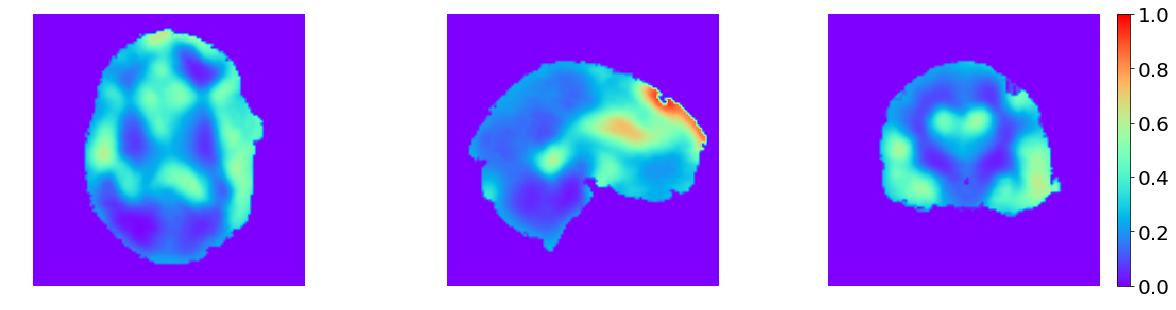

In [10]:
conv_valus = conv_fn(np.array(mri).reshape((-1, 1, 110, 110, 110)))

conv_values = conv_valus[0]

cam = np.zeros(dtype = np.float32, shape = conv_values.shape[1:4])

for j, w in enumerate(class_weights):
    cam += w * conv_values[j, :, :, :]

res = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))


seg0_name = 'image/3DUCM/example_level_00.npy'
seg0 = np.load(seg0_name)
seg0 = np.flipud(seg0)
seg0_array = np.unique(seg0)
vox_cnt = []

for cc in range(len(seg0_array)):
    vox_cnt.append(len(np.where(seg0==seg0_array[cc])[0]))
bg_seg = seg0_array[np.where(np.array(vox_cnt) == max(vox_cnt))[0]][0]

res = resize(res,(110,110,110))
res[np.where(seg0==bg_seg)] = 0

res = resize(res,(256,256,256))

mri_rz = resize(mri,(256,256,256))


fig = plt.figure(figsize=(21, 5))
plt.subplot(1, 3, 1)
plt.axis('off')
matr = rotate(mri_rz[:, :, 128].reshape(256, 256), 90)
plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
plt.hold(True)
matr = rotate(res[:, :, 128].reshape(256, 256), 90)
plt.imshow(matr,
           interpolation=None, vmax=1., vmin=.0, alpha=1,
           cmap=plt.cm.rainbow)
plt.subplot(1, 3, 2)
plt.axis('off')
matr = rotate(mri_rz[128,:, :].reshape(256, 256), 90)
plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
plt.hold(True)
matr = rotate(res[128,:, :].reshape(256, 256), 90)
plt.imshow(matr,
           interpolation=None, vmax=1., vmin=.0, alpha=1,
           cmap=plt.cm.rainbow)
plt.subplot(1, 3, 3)
plt.axis('off')
matr = rotate(mri_rz[:,128, :].reshape(256, 256), 90)
plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
plt.hold(True)
matr = rotate(res[:,128, :].reshape(256, 256), 90)
plt.imshow(matr,
           interpolation=None, vmax=1., vmin=.0, alpha=1,
           cmap=plt.cm.rainbow)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
plt.show()